In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import requests
import nltk
from nltk.corpus import stopwords

In [2]:
!pip freeze > requirements.txt

In [3]:
random_seed = 42

In [173]:
hotels = pd.read_csv('hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


# Creating the baseline model. Dropping object and string columns

In [174]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

The columns lat and lng contain missing values. Let's see the distribution of the values.

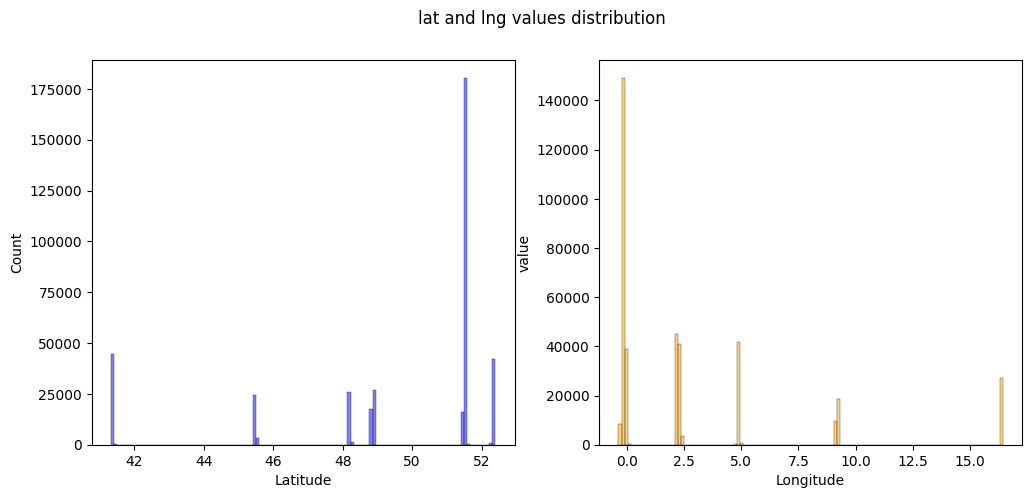

In [175]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=hotels['lat'], color='blue', ax=axes[0], alpha=0.5, label = 'lat')
axes[0].set_xlabel('Latitude')
sns.histplot(data=hotels['lng'], color='orange', ax=axes[1], alpha=0.5, label='lng')
axes[1].set_xlabel('Longitude')

plt.ylabel('value')
plt.suptitle('lat and lng values distribution')
plt.show()

So, the distributions are rather ununiform. The NA values can be filled with the median.

In [176]:
#dropping object and string variables
new_frame = hotels.drop(hotels.select_dtypes(include=['object']).columns, axis=1)
#filling the missing values with median
new_frame['lat'] = new_frame['lat'].fillna(new_frame['lat'].median())
new_frame['lng'] = new_frame['lng'].fillna(new_frame['lng'].median())
hotels['lat'] = hotels['lat'].fillna(new_frame['lat'].median())
hotels['lng'] = hotels['lng'].fillna(new_frame['lng'].median())

In [177]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = new_frame.drop(['reviewer_score'], axis = 1)  
y = new_frame['reviewer_score'] 

In [178]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [179]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [180]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [181]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.14139872134286507


Our metric value can be improved. Let's transfrom the dataset further.

# EDA

Let's divide our vriables into contiguous and categorical ones.

In [182]:
new_frame.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
0,581,8.4,3,1994,4,7,10.0,51.507894,-0.143671
1,299,8.3,3,1361,2,14,6.3,51.521009,-0.123097
2,32,8.9,6,406,0,14,7.5,48.845377,2.325643
3,34,7.5,0,607,11,8,10.0,48.888697,2.394540
4,914,8.5,4,7586,20,10,9.6,52.385601,4.847060


In [183]:
# contiguous variables
num_cols = ['additional_number_of_scoring', 'total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']
# categorical variables
cat_cols = ['average_score', 'lat', 'lng']


Then, let's perform feature selection according to statistical tests for categorical and contiguous variables.

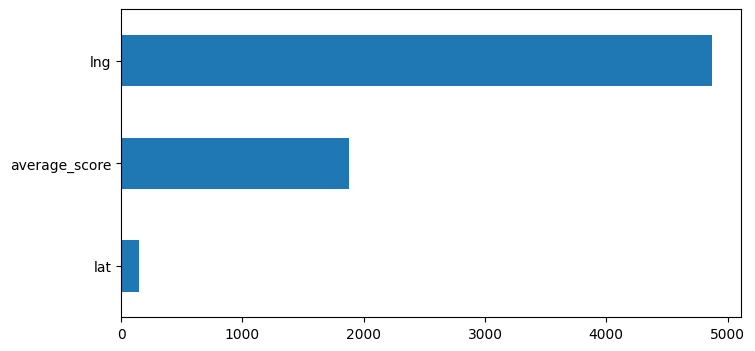

In [184]:
#primary conversion
y=y.astype('int')
X['lat'] = abs(X['lat'])
X['lng'] = abs(X['lng'])

#chi-test for categorical features
from sklearn.feature_selection import chi2 
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');


In [185]:
for variable, p in zip(X[cat_cols], chi2(X[cat_cols], y)[1]):
    print(f'The {variable} p-value is {p}')

The average_score p-value is 0.0
The lat p-value is 1.294984123255352e-27
The lng p-value is 0.0


So, all the variables influence the target value, but lng and average score have more contribution. Let's drop latitude.

In [186]:
hotels = hotels.drop(['lat'], axis=1)
new_frame = new_frame.drop(['lat'], axis=1)

Repeating the same for contiguous values.

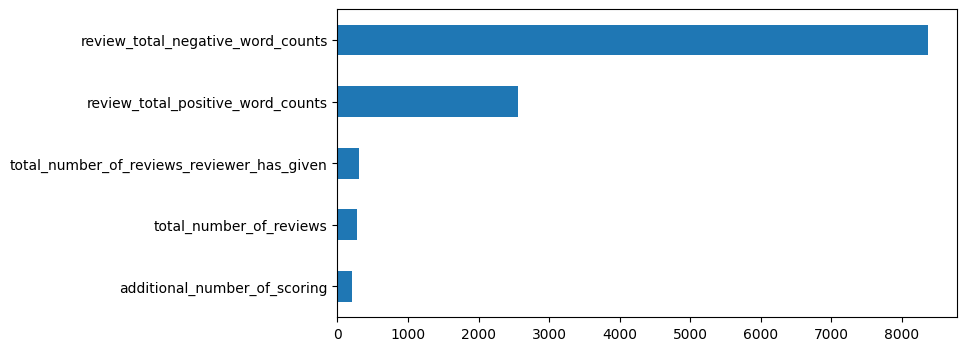

In [187]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

In [188]:
for variable, p in zip(X[num_cols], chi2(X[num_cols], y)[1]):
    print(f'The {variable} p-value is {p}')

The additional_number_of_scoring p-value is 0.0
The total_number_of_reviews p-value is 0.0
The review_total_negative_word_counts p-value is 0.0
The review_total_positive_word_counts p-value is 0.0
The total_number_of_reviews_reviewer_has_given p-value is 0.0


Total numbers of word counts (both negative and positive) have the greatest impact on hotel rating. Therefore, let's drop other variables.

In [189]:
hotels = hotels.drop(['review_total_negative_word_counts', 'total_number_of_reviews_reviewer_has_given', 'additional_number_of_scoring'], axis=1)
new_frame = new_frame.drop(['review_total_negative_word_counts', 'total_number_of_reviews_reviewer_has_given', 'additional_number_of_scoring'], axis=1)

Let's check whether ther's multicorrelation between the remaining variables.

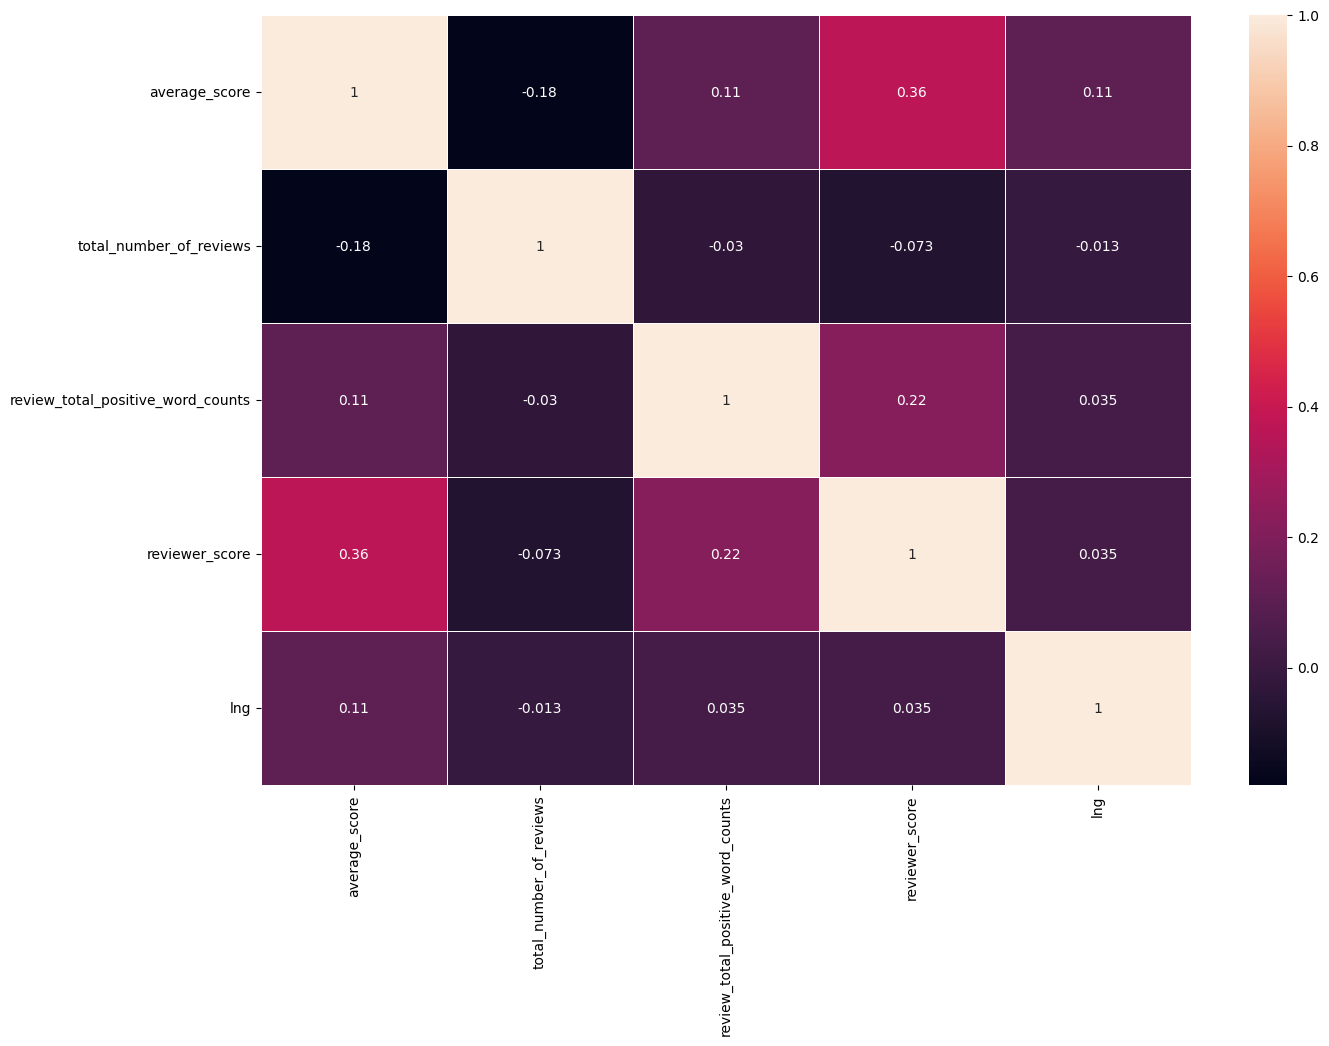

In [190]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(new_frame.select_dtypes(include=['number']).corr(), annot=True, linewidths=.5, ax=ax);

No strong correlations are observed.

# Featue selection

Further work will be held with the primary dataset!

## How many hotel names are in the dataset?

In [191]:
hotels['hotel_name'].unique().shape[0]

1492

## When was the latest feedback given?

In [192]:
pd.to_datetime(hotels['review_date']).sort_values(ascending=True)

143997   2015-08-04
86268    2015-08-04
159209   2015-08-04
217001   2015-08-04
28485    2015-08-04
            ...    
167325   2017-08-03
372341   2017-08-03
54669    2017-08-03
321881   2017-08-03
315137   2017-08-03
Name: review_date, Length: 386803, dtype: datetime64[ns]

Let's extract the year and assign the season of user feedback (highly likely that the feedback was given right after the stay period), assuming that the rating might vary depedning on the year and the season.

In [193]:
#Exctracting the year
hotels['year'] = pd.to_datetime(hotels['review_date']).dt.year

#Creating a function to specify the season 
def assign_season(month):
    if month in [1, 2, 12]:
        return 'Winter'
    elif month >= 3 and month < 6:
        return 'Spring'
    elif month >= 6 and month < 9:
        return 'Summer'
    else:
        return 'Autumn'
    
hotels['season'] = pd.to_datetime(hotels['review_date']).dt.month.apply(assign_season)

Let's encode the year and season and take that the seasons are not ordinal.

In [194]:
encoder = ce.OneHotEncoder(cols=['year', 'season'], use_cat_names=True) # assigning the column to encode
type_bin = encoder.fit_transform(hotels[['year', 'season']]) # feature transformation
hotels = pd.concat([hotels, type_bin], axis=1) # adding the transformed feature

In [195]:
hotels = hotels.drop(['year'], axis=1)

# What is the location of the hotel?

In [29]:
#Fetching the list of countriesfrom API
response = requests.get("https://restcountries.com/v3.1/all", timeout=100)
countries = response.json()
#Extracting country names
country_names = [country['name']['common'] for country in countries]

ConnectionError: HTTPSConnectionPool(host='restcountries.com', port=443): Max retries exceeded with url: /v3.1/all (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000253AD446EC0>: Failed to establish a new connection: [WinError 10061] Подключение не установлено, т.к. конечный компьютер отверг запрос на подключение'))

In [200]:
# Function to extract country from address
def extract_country(address, country_list):
    for country in country_list:
        if country in ' '.join(address.split(' ')[-3:]):
            return country

# Create a new column for the country
hotels['Country'] = hotels['hotel_address'].apply(lambda x: extract_country(address = x, country_list=country_names))

In [201]:
hotels['Country'].unique()

array(['United Kingdom', 'France', 'Netherlands', 'Italy', 'Austria',
       'Spain'], dtype=object)

Since the length of countries list is less than 15-20, let's encode with onehot encoder.

In [202]:
#Performing encoding 
encoder = ce.OneHotEncoder(cols=['Country'], use_cat_names=True)
type_bin = encoder.fit_transform(hotels[['Country']])
hotels = pd.concat([hotels, type_bin], axis=1)

# What is the region of reviewer?

In [ ]:
country_region_mapping = {}

#Create a dictionary of country regions
for country in countries:
        country_name = country['name']['common']#Get the common name of the country
        official_name = country['name']['official']  # Get the official name of the country
        region = country['region']# Get the region of the country
        country_region_mapping[country_name] = region
        country_region_mapping[official_name] = region

# Function to select countries:
def country_region_fun(country, dictionary):
    country = country.strip(' ')
    if country in dictionary:
        return dictionary[country]
    else:
        return 'Unknown'

In [204]:
#Checking the resulting ratios of regions
hotels['reviewer_region'] = hotels['reviewer_nationality'].apply(country_region_fun, dictionary=country_region_mapping)
hotels['reviewer_region'].value_counts()

reviewer_region
Europe       270219
Asia          53828
Americas      36366
Oceania       18742
Africa         6772
Unknown         873
Antarctic         3
Name: count, dtype: int64

In [205]:
#Transforming lowly frequent regions to one category and encoding
other_regions = ['Oceania', 'Africa', 'Unknown', 'Antarctic']
hotels['reviewer_region'] = hotels['reviewer_region'].apply(lambda x: 'Other' if x in other_regions else x)

encoder = ce.OneHotEncoder(cols=['reviewer_region'], use_cat_names=True) # assigning the column to encode
type_bin = encoder.fit_transform(hotels[['reviewer_region']]) # feature transformation
hotels = pd.concat([hotels, type_bin], axis=1) # adding the transformed feature

## How many unique tags are there in the dataset?

In [206]:
tags = list()

#A function to extract most popular tags
def unique_tags(taglist):
    #Processing the taglist
    taglist = taglist.replace("[' ","").replace(" ']", "").split(" ', ' ")
    #Creating a list of unique tags
    for tag in taglist:
        if tag not in tags:
            tags.append(tag)

hotels['tags'].apply(unique_tags)
print(len(tags))

2368


## What is the most popular tag?

In [207]:
popular_tags = dict()

#Counting popular tags with a function
def pop_tags(taglist):
    taglist = taglist.replace("[' ","").replace(" ']", "").split(" ', ' ")
    #Adding a tag count to the dictionary
    for tag in taglist:
        if tag not in popular_tags:
            popular_tags[tag] = 1
        else:
            popular_tags[tag] += 1
            
hotels['tags'].apply(pop_tags)
print(max(popular_tags.items(), key=lambda k: k[1]))

('Leisure trip', 313593)


Possibly, guests having a leisure trip can potentially asssess hotel services higher or lower. We can create another variable for checking whether the guest was staying for vacation.

In [208]:
hotels["leisure_trip"] = hotels['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0 )

Let's see other popular tags.

In [209]:
print(list(popular_tags.keys())[:9])

['Leisure trip', 'Couple', 'Studio Suite', 'Stayed 2 nights', 'Submitted from a mobile device', 'Business trip', 'Standard Double Room', 'Stayed 1 night', 'Solo traveler']


Let's suppose that 'Couple', 'Business trip', and 'Solo traveler' also impact our target variable. Creating additional variables.

In [210]:
for state in ['Couple', 'Business trip', 'Solo traveler']:
    #renaming the headers
    name = '_'.join(state.split(' '))
    #creating a feature
    hotels[name] = hotels['tags'].apply(lambda x: 1 if state in x else 0 )

# Whiat is the most popular feedback word?

In [211]:
#setting stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [212]:
popular_rew = dict()

#Writing a function to count most popular
# positive feedback word
def pop_rev(rlist, dictionary):
    #creating a list of words
    rlist = rlist.lower().strip(' ').split(' ')
    #deleting stopwords
    rlist = [word for word in rlist if word.lower() not in stop_words]
    #counting the number of words
    for word in rlist:
        if word not in dictionary:
            dictionary[word] = 1
        else:
            dictionary[word] += 1

#Applying the function
hotels['positive_review'].apply(pop_rev, dictionary=popular_rew)
print(sorted(popular_rew.items(),
      key=lambda k: k[1], reverse=True)
    )

[('staff', 145874), ('location', 144568), ('room', 105728), ('hotel', 94000), ('good', 84480), ('great', 79160), ('friendly', 63870), ('breakfast', 63307), ('helpful', 57201), ('nice', 52027), ('clean', 50250), ('excellent', 46761), ('comfortable', 44843), ('bed', 37464), ('rooms', 30252), ('positive', 27288), ('lovely', 26269), ('stay', 24106), ('close', 23219), ('station', 21955), ('really', 21214), ('everything', 20345), ('perfect', 19399), ('service', 19393), ('well', 17877), ('quiet', 16445), ('amazing', 16166), ('comfy', 15984), ('walk', 15291), ('bar', 14663), ('us', 13970), ('would', 13645), ('bathroom', 13172), ('also', 13170), ('view', 13004), ('modern', 12625), ('london', 12505), ('food', 12306), ('metro', 12038), ('fantastic', 12034), ('reception', 11885), ('area', 11883), ('free', 11846), ('facilities', 11747), ('spacious', 11646), ('city', 11533), ('beds', 11092), ('easy', 11091), ('beautiful', 10643), ('central', 10242), ('restaurant', 10022), ('near', 9887), ('restauran

Seems like 'staff' could have the greatest impact on hotel ratings due to its hifgh frequency (near the third of all observations). Let's add the variable.

In [213]:
hotels['staff'] = hotels['positive_review'].apply(lambda x: 1 if 'staff' in x else 0)

Let's do the same for negative reviews.

In [214]:
popular_neg_rew = dict()

#Applying the function
hotels['negative_review'].apply(pop_rev, dictionary=popular_neg_rew)
print(sorted(popular_neg_rew.items(),
      key=lambda k: k[1], reverse=True)
    )

[('room', 132025), ('negative', 97092), ('hotel', 55916), ('breakfast', 43528), ('small', 37372), ('staff', 29670), ('nothing', 29016), ('rooms', 26166), ('would', 24324), ('could', 24033), ('bed', 22291), ('one', 21052), ('bit', 20583), ('bathroom', 20004), ('night', 18003), ('like', 16800), ('little', 16781), ('shower', 15970), ('good', 15577), ('us', 15304), ('get', 14713), ('service', 14517), ('bar', 14423), ('stay', 13159), ('time', 13126), ('reception', 12513), ('expensive', 12510), ('really', 12378), ('also', 12373), ('poor', 12104), ('even', 11580), ('price', 11561), ('check', 11495), ('day', 11341), ('floor', 11194), ('water', 10701), ('2', 10470), ('noisy', 10414), ('air', 9940), ('work', 9706), ('coffee', 9541), ('wifi', 9498), ('door', 9450), ('better', 9136), ('hot', 9093), ('quite', 8988), ('noise', 8884), ('much', 8673), ('booking', 8593), ('food', 8556), ('two', 8463), ('location', 8204), ('area', 8147), ('asked', 8060), ('restaurant', 7967), ('old', 7900), ('4', 7818),

Here, 'room' has the highest frequency. Possibly, clients dissatisfaction with room services can have an impact on hotel ratings. Let's add another variable.

In [215]:
hotels['room_negative'] = hotels['negative_review'].apply(lambda x: 1 if 'room' in x else 0)

## What is the most common number of spent nights?

In [216]:
nights = ['night', 'nights']
night_tags = dict()

#Counting the number of popular tags
for tag, number in popular_tags.items():
    for item in nights:
        if item in tag:
            night_tags[tag] = number
print(max(night_tags.items(), key=lambda k: k[1]))

('Stayed 1 night', 145373)


Let's suppose that whether the guest stayed 1 night or not can influence the rating significantly, as the longer time spent at the hotel can reveal the nuances more.

In [217]:
hotels["stayed_1_night"] = hotels['tags'].apply(lambda x: 1 if 'Stayed 1 night' in x else 0 )

# Feature standartisation and selection

Let's drop the remaining object variables, since most information has already beem retreived.

In [218]:
hotels = hotels.drop(hotels.select_dtypes(include=['object']).columns, axis=1)

In [219]:
hotels.columns

Index(['average_score', 'total_number_of_reviews',
       'review_total_positive_word_counts', 'reviewer_score', 'lng',
       'year_2016.0', 'year_2017.0', 'year_2015.0', 'season_Winter',
       'season_Autumn', 'season_Spring', 'season_Summer',
       'Country_United Kingdom', 'Country_France', 'Country_Netherlands',
       'Country_Italy', 'Country_Austria', 'Country_Spain',
       'reviewer_region_Europe', 'reviewer_region_Asia',
       'reviewer_region_Other', 'reviewer_region_Americas', 'leisure_trip',
       'Couple', 'Business_trip', 'Solo_traveler', 'staff', 'room_negative',
       'stayed_1_night'],
      dtype='object')

New lists of categorical and contiguous values.

In [220]:
cat_cols = ['average_score', 'lng',
       'year_2016.0', 'year_2017.0', 'year_2015.0', 'season_Winter',
       'season_Autumn', 'season_Spring', 'season_Summer',
       'Country_United Kingdom', 'Country_France', 'Country_Netherlands',
       'Country_Italy', 'Country_Austria', 'Country_Spain',
       'reviewer_region_Europe', 'reviewer_region_Asia',
       'reviewer_region_Other', 'reviewer_region_Americas', 'leisure_trip',
       'Couple', 'Business_trip', 'Solo_traveler', 'staff', 'room_negative',
       'stayed_1_night']
num_cols = ['total_number_of_reviews',
       'review_total_positive_word_counts']

Let's check for normalty of distribution

In [221]:
from scipy.stats import shapiro

for feature in num_cols:
    stat, p_value = shapiro(hotels[feature])
    print('Shapiro-Wilk Test Statistic:', stat)
    print('P-Value:', p_value)
    if p_value > 0.05:
        print("{} is NOT normally distributed".format(feature))
    else:
        print("{} is normally distributed".format(feature))

Shapiro-Wilk Test Statistic: 0.8171118497848511
P-Value: 0.0
total_number_of_reviews is normally distributed
Shapiro-Wilk Test Statistic: 0.6625810861587524
P-Value: 0.0
review_total_positive_word_counts is normally distributed


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The data is normally distributed, but the ranges a different. Let's standardise data.

In [222]:
from sklearn import preprocessing

st_scaler = preprocessing.StandardScaler()
# standardising
hotels[num_cols] = st_scaler.fit_transform(hotels[num_cols])

## Checking for multicollinearity

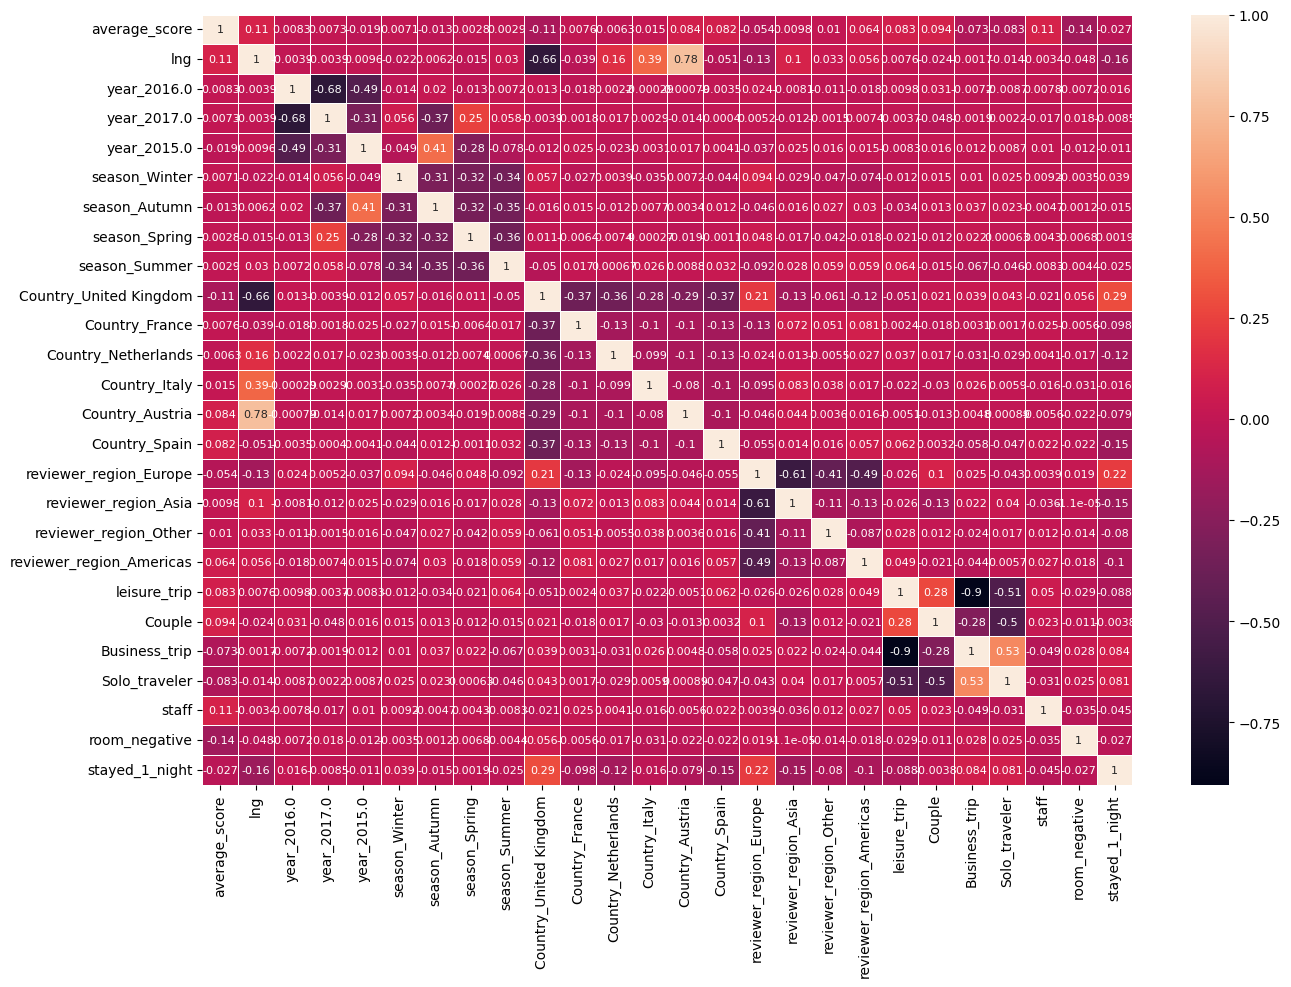

In [223]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(hotels[cat_cols].corr(), annot=True, linewidths=.5, ax=ax, annot_kws={"size": 8});

Business trip correlates with leisure trip. So, the variable is redundant. Deleting the created variable, for sure. 'Country Austria' correlates with lng. Besides, the feature has rather sound correlations with lng, assuming that both variables reflect the location of the hotel. However, correlations are small between the countries. Therefore, we can try to delete langitude.

In [224]:
hotels = hotels.drop('Business_trip', axis=1)
hotels_fin = hotels.drop('lng', axis=1)

In [225]:
cat_cols = ['average_score',
 'year_2016.0',
 'year_2017.0',
 'year_2015.0',
 'season_Winter',
 'season_Autumn',
 'season_Spring',
 'season_Summer',
 'Country_United Kingdom',
 'Country_France',
 'Country_Netherlands',
 'Country_Italy',
 'Country_Austria',
 'Country_Spain',
 'reviewer_region_Europe',
 'reviewer_region_Asia',
 'reviewer_region_Other',
 'reviewer_region_Americas',
 'leisure_trip',
 'Couple',
 'Solo_traveler',
 'staff',
 'room_negative',
 'stayed_1_night']

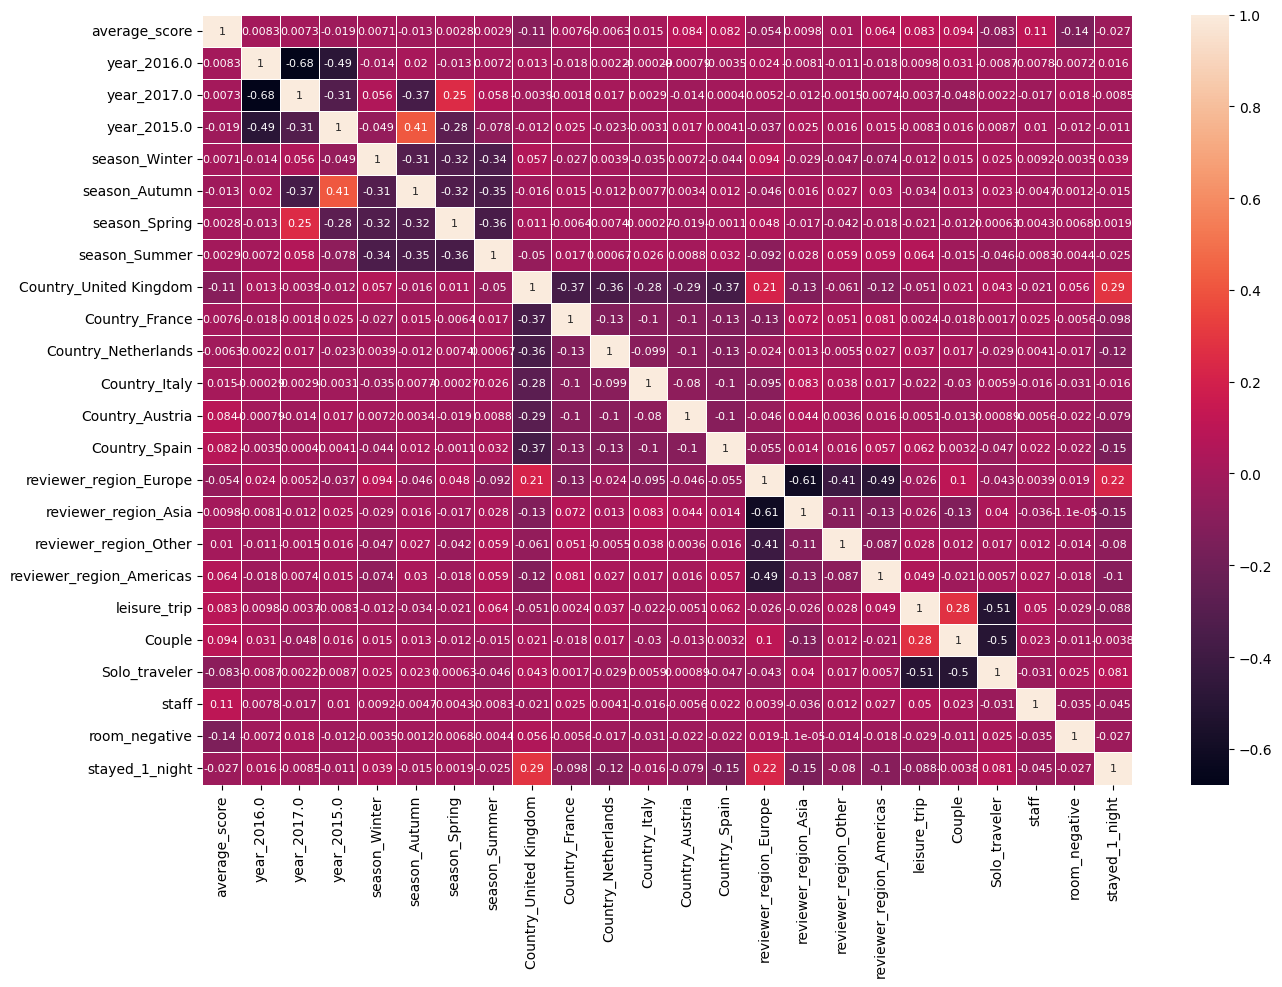

In [226]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(hotels_fin[cat_cols].corr(), annot=True, linewidths=.5, ax=ax, annot_kws={"size": 8});

Years have rather high correlations. We can also try to remove them

In [227]:
hotels_fin = hotels_fin.drop(['year_2016.0', 'year_2017.0'], axis=1)

In [228]:
cat_cols = ['average_score',
 'year_2015.0',
 'season_Winter',
 'season_Autumn',
 'season_Spring',
 'season_Summer',
 'Country_United Kingdom',
 'Country_France',
 'Country_Netherlands',
 'Country_Italy',
 'Country_Austria',
 'Country_Spain',
 'reviewer_region_Europe',
 'reviewer_region_Asia',
 'reviewer_region_Other',
 'reviewer_region_Americas',
 'leisure_trip',
 'Couple',
 'Solo_traveler',
 'staff',
 'room_negative',
 'stayed_1_night']

Let's check for feature weight for prediction.

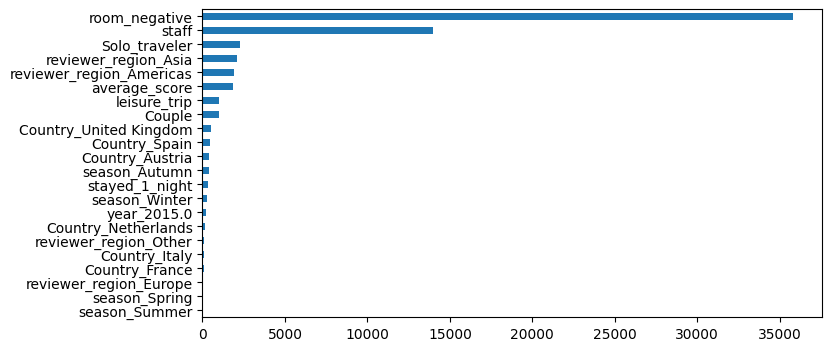

In [229]:
hotels_chi = hotels_fin.copy()
y=y.astype('int')

imp_cat = pd.Series(chi2(hotels_chi[cat_cols], hotels_chi['reviewer_score'].astype(int))[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

In [230]:
hotels_fin = hotels_fin.drop(['Country_Austria', 'Country_Spain', 'Country_United Kingdom','season_Autumn', 'stayed_1_night', 'season_Winter', 'year_2015.0','season_Spring', 'season_Summer','Country_France', 'Country_Italy',  'reviewer_region_Other',  'Country_Netherlands'], axis =1)

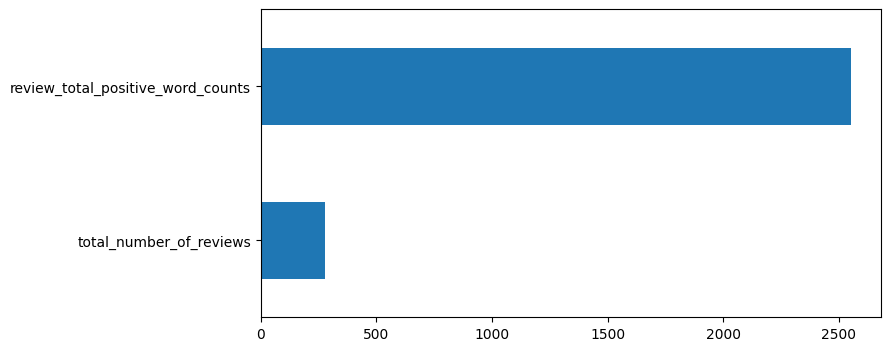

In [231]:
plt.rcParams['figure.figsize'] = (8,4)
imp_num = pd.Series(f_classif(hotels_fin[num_cols], hotels_fin['reviewer_score'].astype(int))[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

In [232]:
hotels_fin = hotels_fin.drop('total_number_of_reviews', axis=1)

# Model 

In [233]:
X = hotels_fin.drop(['reviewer_score'], axis = 1)  
y = hotels_fin['reviewer_score'] 

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [235]:
#Model 
regr = RandomForestRegressor(n_estimators=100)  
      
# Training 
regr.fit(X_train, y_train)  
y_pred = regr.predict(X_test)  


In [236]:
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.15455189963680674


# Competition submission

In [ ]:
predict_submission = regr.predict(test_data)
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

